# Problem Set 3
Use the LendingClub_LoanStats3a_v12.csv dataset available at BruinLearn (Week 3) for this
exercise. The data is downloaded from Lending Club's website and there is additional
information about the data there (although they now require that you sign up for a user
profile.

## Question 1: Predicting default
a. We will use the column "loan_status" as the indicator for whether the loan was paid or
there was a default.
* (i) Drop all rows where "loan_status" is not equal to either "Fully Paid" or "Charged Off." Define the new variable Default as 1 (or TRUE) if "loan_status" is equal to "Charged Off", and 0 (or FALSE) otherwise.

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.discrete.discrete_model import Logit
from scipy.optimize import minimize

from patsy import dmatrices

os.chdir('/Users/yiyujie/Desktop/program/ML')
data = pd.read_csv('LendingClub_LoanStats3a_v12.csv',low_memory=False)

In [2]:
data = data[data.loan_status.isin(['Fully Paid','Charged Off'])].reset_index(drop=True)
data['Default'] = data['loan_status'].apply(lambda x : 1 if x == 'Charged Off' else 0)

* (ii) Report the average default rate in the sample (number of defaults divided by total number of loans)

In [3]:
data['Default'].mean()

0.14353496397036436

b. LendingClub gives a "grade" to each borrower, designed as a score of each borrowers creditworthiness. The best grade is "A", the worst grade is "G".
* (i) Run a logistic regression of the Default variable on the grade. Report and explain the regression output. I.e., what is the interpretation of the coefficients? Do the numbers 'make sense'.

In [4]:
y, Xf = dmatrices('Default ~ C(grade)', data, return_type = 'dataframe')
logit_model = sm.GLM(y, Xf, family=sm.families.Binomial()).fit()
print(logit_model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                Default   No. Observations:                39412
Model:                            GLM   Df Residuals:                    39405
Model Family:                Binomial   Df Model:                            6
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -15457.
Date:                Sat, 20 Apr 2024   Deviance:                       30914.
Time:                        16:48:14   Pearson chi2:                 3.94e+04
No. Iterations:                     6   Pseudo R-squ. (CS):            0.03754
Covariance Type:            nonrobust                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -2.7554      0.042    -65.554

* The negative intercept indicates that borrowers with grade A are less likely to default.
* All coefficients are positive and increase with the grade getting worse, which implies higher odds of defaulting as the creditworthiness decreases from 'A' down to 'G'.

* (ii) Construct and report a test of whether the model performs better than the null model where only "beta0", and no conditioning information, is present in the logistic model.

In [5]:
from scipy.stats import chi2
test_stat = logit_model.null_deviance - logit_model.deviance
p_value_chisq = 1 - chi2.cdf(test_stat,1)
print("test_stat:", test_stat,", p_value_chisq:", p_value_chisq)

test_stat: 1508.0972556752204 , p_value_chisq: 0.0


* A larger test statistic indicates that the full model provides a significantly better fit to the data than the null model.
* The p-value is essentially 0, which indicates that the result is highly significant statistically. 

* (iii) Construct the lift table and the ROC curve for this model. When constructing these, think a little about the nature of your model. For instance, does it make sense to use deciles in the lift table or would a different type of cutoff be more sensible? Explain the interpretation of the numbers in the lift table and the lines and axis in the ROC curve. Does the model perform better than a random guess?

In [6]:
data['prob'] = logit_model.predict(Xf)
lift = data[['grade','prob','Default']].groupby('grade').mean()
lift['Lift Factor'] = lift['Default'] / data.Default.mean()
lift

,prob,Default,Lift Factor
grade,,,
A,0.059782,0.059782,0.416495
B,0.119836,0.119836,0.834889
C,0.168577,0.168577,1.174467
D,0.214939,0.214939,1.497468
E,0.257868,0.257868,1.796554
F,0.313840,0.313840,2.186507
G,0.322684,0.322684,2.248119


* For grade A, the lift factor is 0.416495, which indicates that borrowers with grade A are less likely to default than would be expected by random chance.
* For grades A through G, the lift factors value are increasing as the grades go from A to G. This indicates that the model is increasingly effective at predicting defaults as the grades decrease from A to G. 

Text(0.5, 1.0, 'ROC curve based on grades')

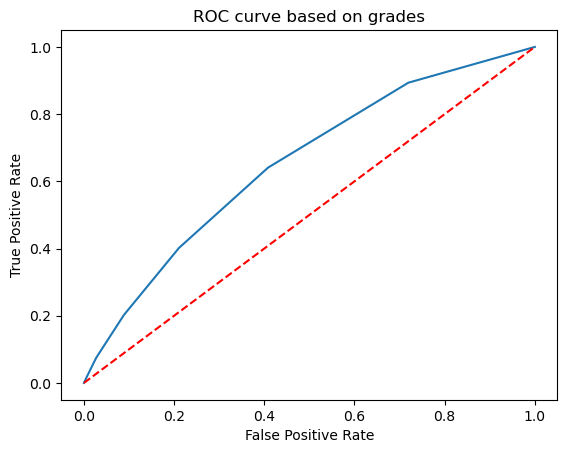

In [7]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(data['Default'], data['prob'])
plt. plot(fpr, tpr)
plt. plot([0, 1], [0, 1], 'r--')
plt. xlabel('False Positive Rate')
plt. ylabel('True Positive Rate')
plt. title('ROC curve based on grades')

* The ROC curve lies above the diagonal line, so it performs better than a random guess. 

* (iv) Assume that each loan is for $\$100$, and that you make a $\$1$ profit if there is no default, but lose $\$10$ if there is a default (both given in present value terms to keep things easy). Using data from the ROC curve (True Positive Rate and False Positive Rate) along with the average rate of default (total number of defaults divided by total number of loans), what is the cutoff default probability you should use as your decision criterion to maximize profits? Plot the corresponding point on the ROC curve.

In [8]:
default_rate = data['Default'].mean()
profits = tpr * default_rate * (-10) + (1 - fpr) * (1 - default_rate) * 1
index = np.argmax(profits)
optimal_threshold = thresholds[index]
print("max_profit_index: ", index, "\nprofits: ", profits, "\noptimal_threshold: ", optimal_threshold)

max_profit_index:  0 
profits:  [ 0.85646504  0.82545925  0.72589567  0.49030752  0.09956358 -0.41304679
 -1.04237288 -1.43534964] 
optimal_threshold:  1.3226837060702872


* This threshold value indicates a very conservative approach to lending, suggesting lending only to those with a very low predicted probability of defaulting.

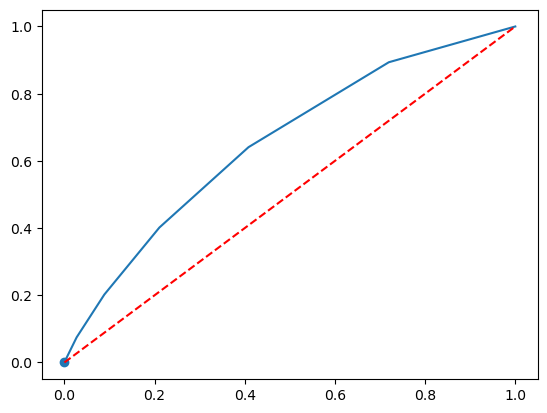

In [9]:
plt.plot(fpr, tpr)
plt. plot([0, 1], [0, 1], 'r--')
plt.scatter(fpr[0], tpr[0], label='Optimal Threshold')

c. Next, we will see if it is possible to do better than the internal "grade"-variable, using
other information about the borrower and the loan as provided by LendingClub
* (i) First, consider a logistic regression model that uses only loan amount (loan_amnt) and annual income (annual_inc) as explanatory variables. Report the regression results. Show the lift table, comparing to the 'grade'-model from
    * a. Plot the ROC curves of both the 'grade'-model and the alternative model. Which model performs better?

In [10]:
y, Xf_2 = dmatrices('Default ~ loan_amnt + annual_inc', data, return_type = 'dataframe')
logit_model_2 = sm.GLM(y, Xf_2, family=sm.families.Binomial()).fit()
print(logit_model_2.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                Default   No. Observations:                39412
Model:                            GLM   Df Residuals:                    39409
Model Family:                Binomial   Df Model:                            2
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -16013.
Date:                Sat, 20 Apr 2024   Deviance:                       32027.
Time:                        16:48:15   Pearson chi2:                 6.67e+04
No. Iterations:                     6   Pseudo R-squ. (CS):           0.009993
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.7254      0.032    -53.708      0.0

In [11]:
data['prob_2'] = logit_model_2.predict(Xf_2)
lift_2 = data[['grade','prob_2','Default']].groupby('grade').mean()
lift_2['Lift Factor'] = lift_2['Default'] / data.Default.mean()
pd.concat([lift,lift_2],axis=1)

,prob,Default,Lift Factor,prob_2,Default,Lift Factor
grade,,,,,,
A,0.059782,0.059782,0.416495,0.134135,0.059782,0.416495
B,0.119836,0.119836,0.834889,0.143937,0.119836,0.834889
C,0.168577,0.168577,1.174467,0.144146,0.168577,1.174467
D,0.214939,0.214939,1.497468,0.147960,0.214939,1.497468
E,0.257868,0.257868,1.796554,0.156897,0.257868,1.796554
F,0.313840,0.313840,2.186507,0.161399,0.313840,2.186507
G,0.322684,0.322684,2.248119,0.162852,0.322684,2.248119


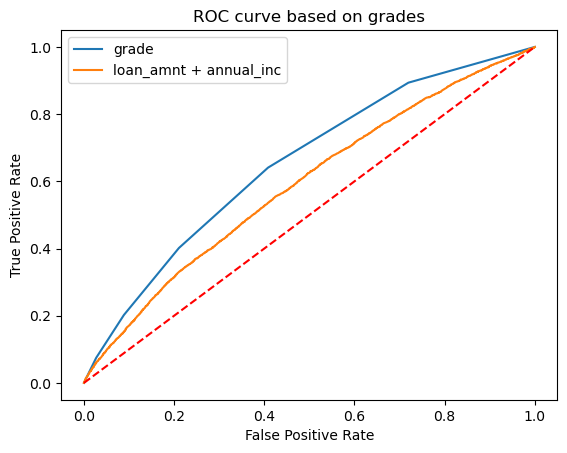

In [12]:
fpr_2, tpr_2, thresholds_2 = roc_curve(data['Default'], data['prob_2'])
plt. plot(fpr, tpr, label = 'grade')
plt. plot(fpr_2, tpr_2, label = 'loan_amnt + annual_inc')
plt. plot([0, 1], [0, 1], 'r--')
plt. xlabel('False Positive Rate')
plt. ylabel('True Positive Rate')
plt. title('ROC curve based on grades')
plt.legend()

* The grade model performs better, we can see that from the ROC curve.

* (ii) Now, include also information from the loan itself. In particular, include the maturity of the loan (term) and the interest rate (int_rate) in the logistic regression. Report the output. How does Python handle the term variable? In particular, what is the interpretation of the regression coefficient? Again show the lift table and ROC curve relative to the original 'grade' model. Now, which model is better? What is the likely explanation for why this new model performs better/worse?

In [13]:
y, Xf_3 = dmatrices('Default ~ loan_amnt + annual_inc + int_rate + C(term)', data, return_type = 'dataframe')
logit_model_3 = sm.GLM(y, Xf_3, family=sm.families.Binomial()).fit()
print(logit_model_3.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                Default   No. Observations:                39412
Model:                            GLM   Df Residuals:                    39407
Model Family:                Binomial   Df Model:                            4
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -15209.
Date:                Sat, 20 Apr 2024   Deviance:                       30418.
Time:                        16:48:15   Pearson chi2:                 4.68e+04
No. Iterations:                     6   Pseudo R-squ. (CS):            0.04958
Covariance Type:            nonrobust                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                -3.26

* The coefficient for C(term)$[T. 60 months]$ of 0.4538 indicates the change in the log-odds of default for a '60 months' term loan relative to the reference category of '36 months', while holding other variables constant. Since the coefficient is positive, it suggests that loans with a term of '60 months' are associated with higher odds of default compared to loans with a term of '36 months'.

In [14]:
data['prob_3'] = logit_model_3.predict(Xf_3)
lift_3 = data[['grade','prob_3','Default']].groupby('grade').mean()
lift_3['Lift Factor'] = lift_3['Default'] / data.Default.mean()
pd.concat([lift,lift_3],axis=1)

,prob,Default,Lift Factor,prob_3,Default,Lift Factor
grade,,,,,,
A,0.059782,0.059782,0.416495,0.068141,0.059782,0.416495
B,0.119836,0.119836,0.834889,0.115441,0.119836,0.834889
C,0.168577,0.168577,1.174467,0.159341,0.168577,1.174467
D,0.214939,0.214939,1.497468,0.209062,0.214939,1.497468
E,0.257868,0.257868,1.796554,0.272785,0.257868,1.796554
F,0.313840,0.313840,2.186507,0.330215,0.313840,2.186507
G,0.322684,0.322684,2.248119,0.369736,0.322684,2.248119


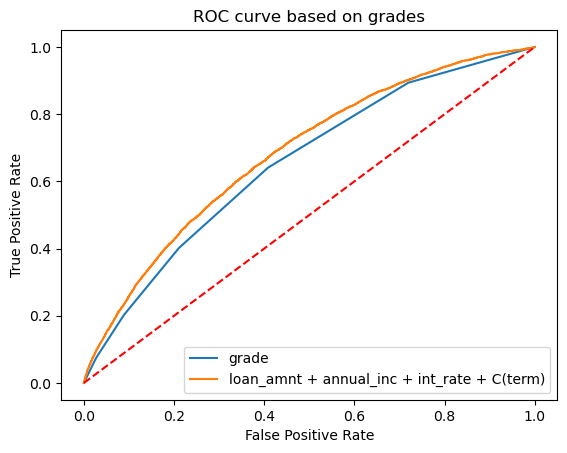

In [15]:
fpr_3, tpr_3, thresholds_3 = roc_curve(data['Default'], data['prob_3'])
plt. plot(fpr, tpr, label = 'grade')
plt. plot(fpr_3, tpr_3, label = 'loan_amnt + annual_inc + int_rate + C(term)')
plt. plot([0, 1], [0, 1], 'r--')
plt. xlabel('False Positive Rate')
plt. ylabel('True Positive Rate')
plt. title('ROC curve based on grades')
plt.legend()

* The new model performs better, since it adds additional relevant predictors. The term length also plays a role because longer-term loans might have a higher risk of default due to the extended time horizon for potential financial changes in the borrower's life.

* (iii) Create the squared of the interest rate and add this variable to the last model. Is the coefficient on this variable significant? Please give an intuition for what the coefficients on both int_rate and its squared value imply for the relationship between defaults and the interest rate.

In [16]:
data['int_rate2'] = data['int_rate']**2
y, Xf_4 = dmatrices('Default ~ loan_amnt + annual_inc + int_rate + C(term) + int_rate2', data, return_type = 'dataframe')
logit_model_4 = sm.GLM(y, Xf_4, family=sm.families.Binomial()).fit()
print(logit_model_4.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                Default   No. Observations:                39412
Model:                            GLM   Df Residuals:                    39406
Model Family:                Binomial   Df Model:                            5
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -15196.
Date:                Sat, 20 Apr 2024   Deviance:                       30393.
Time:                        16:48:16   Pearson chi2:                 4.55e+04
No. Iterations:                     6   Pseudo R-squ. (CS):            0.05020
Covariance Type:            nonrobust                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                -4.03

* The positive linear term and the negative squared term suggest an inverted U-shaped relationship: as the interest rate increases, the probability of default first increases at a decreasing rate and then starts to decrease after a certain point.